<a href="https://colab.research.google.com/github/nso3075/Diabetes-LDA-Machine-Learning/blob/main/LDA_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Upload Dataset Here

In [ ]:
!wget -O dataset.csv "https://drive.google.com/uc?id=1pMe94VDzVEQYnjQY6daMLBqaQeDfhNYh"


--2024-12-09 19:49:37--  https://drive.google.com/uc?id=1pMe94VDzVEQYnjQY6daMLBqaQeDfhNYh
Resolving drive.google.com (drive.google.com)... 172.217.15.238, 2607:f8b0:4025:815::200e
Connecting to drive.google.com (drive.google.com)|172.217.15.238|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1pMe94VDzVEQYnjQY6daMLBqaQeDfhNYh [following]
--2024-12-09 19:49:37--  https://drive.usercontent.google.com/download?id=1pMe94VDzVEQYnjQY6daMLBqaQeDfhNYh
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.15.225, 2607:f8b0:4025:802::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.15.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22738151 (22M) [application/octet-stream]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>]  21.68M  51.5MB/s    in 0.4s    

2024-12-09 19:49:41 (51.5 MB/s) - ‘dataset.

# **Linear Discriminant Analysis**

---

#### Overview
- Implementing **Linear Discriminant Analysis (LDA) for multi-class classification on CDC Diabetes Dataset
- Asses LDA's accuracy with different classifiers: linear classifier and random forest.

---

#### Important Features
- **Core Libraries**:  
  - `numpy`, `pandas`, `matplotlib`, `sklearn`.
  - **sklearn** is ONLY used for Random Forest NOT LDA (as required by the assignment instructions).
- **Key Functions**:  
  - `graph_2D_scatter`: Create 2D scatterplots of LDA projections.  
  - `conf_matrix`: Generate confusion matrices with recognition rates.  
  - `perform_lda`: Implement LDA with scatter matrix computations.  
  - `lda_search_fn`: Classify and assess accuracy using LDA.  
  - `rf_search_fn`: Apply Random Forest for classification.  
  - `lda_rf_pipeline`: Combine LDA + Random Forest to evaluate trends.

---

#### Outputs
- Scatterplots to visualize LDA projections (both 2D and 3D).  
- Line charts to depict accuracy trends and feature contributions.
- Bar graph to demonstrate LDA and its impact on Random Forest
- Confusion matrices


### Usage
- To run the code faster, we reccomend decreasing the value of frac in this line:
```
data = data.sample(frac=0.8, random_state=42)
```
*Setting frace to 0.1 will still test use 10000 samples*

- The first cell runs the grid search and produces confusion matrices for the different LDA projections.
- Feel free to adjust the number of components explored in the grid search (currently, it is 12).
- There is an option to not print confusion matrices.
- You can change the number of estimators used in the grid search when testing Random Forest
- To get the 3D scatter plot, please change the parameter plot_3D to equal True when calling process_data_file



Processing file: dataset.csv

LDA + Random Forest Pipeline:
Testing LDA with 1 components

>>> LDA Classifier Results

    Recognition rate (correct / inputs):
  65.97%

	Confusion Matrix:
		| 0: No Diabetes | 1: Type One | 2: Type Two
     ---------------------------------------------
0: Pred-Class-0 |      11653        110        535
1: Pred-Class-1 |       2827        102        713
2: Pred-Class-2 |       2543        178       1634



Testing LDA with 2 components

>>> LDA Classifier Results

    Recognition rate (correct / inputs):
  65.71%

	Confusion Matrix:
		| 0: No Diabetes | 1: Type One | 2: Type Two
     ---------------------------------------------
0: Pred-Class-0 |      11614        110        521
1: Pred-Class-1 |       2825        107        746
2: Pred-Class-2 |       2584        173       1615



Testing LDA with 3 components

>>> LDA Classifier Results

    Recognition rate (correct / inputs):
  65.71%

	Confusion Matrix:
		| 0: No Diabetes | 1: Type One | 2: Type T

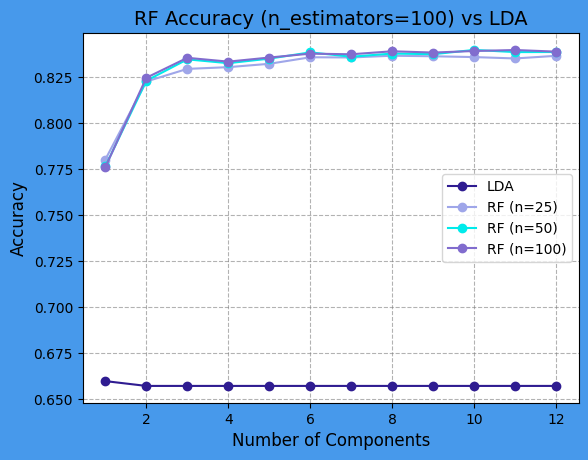

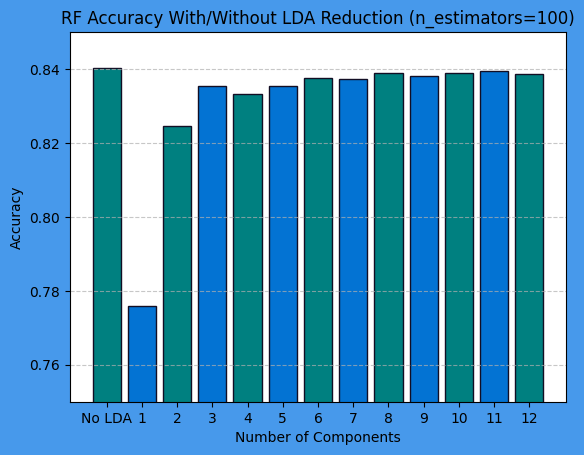

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# These are for the Random Forest Classifier (NOT LDA)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Set seed at 42 for reproducability
sd = 42
np.random.seed(sd)
colors = ['#008080', '#0373d3', '#816cce', '#00ebeb', '#9fa6e9', '#2f1c91']

# Plot a 2D scatter plot for LDA projections with two components
def graph_2D_scatter(X_train, y_train, eigvecs):
    plt.figure(facecolor='#4799eb')

    # Select top two eigenvalues and project them
    W = eigvecs[:, :2]
    X_train_lda = X_train @ W

    # Separate data into classes
    class_0 = X_train_lda[y_train == 0.0]
    class_1 = X_train_lda[y_train == 1.0]
    class_2 = X_train_lda[y_train == 2.0]

    # Plot data in scatter
    plt.scatter(class_0[:, 0], class_0[:, 1], marker=".", color=colors[4], label="Class 0")
    plt.scatter(class_1[:, 0], class_1[:, 1], marker=".", color=colors[2], label="Class 1")
    plt.scatter(class_2[:, 0], class_2[:, 1], marker=".", color=colors[1], label="Class 2")

    plt.legend()
    plt.title("LDA Projection (2D)")
    plt.xlabel("LD1")
    plt.ylabel("LD2")
    plt.savefig("lda_projection_2D.png")
    plt.close()

# Compute and print a confusion matrox
def conf_matrix(y_pred, y_true, title=None):
    confusions = np.zeros((3,3), dtype=int)
    for pred, true in zip(y_pred, y_true):
        confusions[int(pred)][int(true)] += 1

    # Compute the recognition rate
    inputs_correct = np.sum([confusions[i][i] for i in range(3)])
    inputs_total = np.sum(confusions)
    recognition_rate = inputs_correct / inputs_total * 100

    # Print results
    if title:
        print("\n>>> " + title)
    print(
        f"\n    Recognition rate (correct / inputs):\n  {recognition_rate:.2f}%\n"
    )
    print("\tConfusion Matrix:")
    print("\t\t| 0: No Diabetes | 1: Type One | 2: Type Two")
    print("     ---------------------------------------------")
    for i, row in enumerate(confusions):
        print(
            f"{i}: Pred-Class-{i} | "
            + " ".join(f"{val:10d}" for val in row)
        )
    print("\n\n")
    return confusions, recognition_rate

# Perform LDA!
def perform_lda(X_train, y_train, X_test):
    classes = np.unique(y_train)
    mean_vectors = {c: np.mean(X_train[y_train == c], axis=0) for c in classes}
    mean_overall = np.mean(X_train, axis=0)

    # Centralize the data
    X_train_norm = X_train - mean_overall
    X_test_norm = X_test - mean_overall

    num_features = X_train.shape[1]
    wc_ms = np.zeros((num_features, num_features)) # within-class scatter matrix
    bc_ms = np.zeros((num_features, num_features)) # between-class scatter matrix

    # Calculate the scatter matrices
    for c in classes:
        class_data = X_train[y_train == c]
        mean_c = mean_vectors[c].reshape(-1, 1)
        wc_ms += np.sum([(x.reshape(-1, 1) - mean_c) @ (x.reshape(-1, 1) - mean_c).T for x in class_data], axis=0)
        num_samples_c = class_data.shape[0]
        mean_diff = (mean_vectors[c] - mean_overall).reshape(-1, 1)
        bc_ms += num_samples_c * (mean_diff @ mean_diff.T)

    # Get eigenvalues and eigenvectors for new matrix
    new_mat = np.linalg.pinv(wc_ms) @ bc_ms
    eigenvalues, eigenvectors = np.linalg.eig(new_mat)

    # Sort eigenvalues and eigen vectors into ascending order
    sorted_indices = np.argsort(-eigenvalues.real)
    eigvecs = eigenvectors[:, sorted_indices].real

    # Plot a 2D_scatter matrix
    graph_2D_scatter(X_train_norm, y_train, eigvecs)

    # Function ro project data onto selected eigenvectors (n components)
    def project_data(n_components):
        W = eigvecs[:, :n_components]
        W = eigvecs[:, :n_components]
        X_train_lda = X_train_norm @ W
        X_test_lda = X_test_norm @ W
        return X_train_lda, X_test_lda

    return project_data

# LDA classification using euclidean distance to class means
def lda_search_fn(X_train_lda, y_train, X_test_lda, y_test, get_cms=False):
    # Calculate mean for each class in projected data
    class_means_lda = {c: np.mean(X_train_lda[y_train == c], axis=0) for c in np.unique(y_train)}

    # Predict by finding the closest class mean for a given point
    def predict(x):
        distances = {c: np.linalg.norm(x - mean) for c, mean in class_means_lda.items()}
        return min(distances, key=distances.get)

    # Predict for all test samples
    y_pred = np.array([predict(x) for x in X_test_lda])

    # Print confusion matrices (optional)
    if get_cms: conf_matrix(y_pred, y_test, title = "LDA Classifier Results")
    return accuracy_score(y_test, y_pred)

# Search function for Random Forest
def rf_search_fn(X_train, y_train, X_test, y_test, n_estimators):
    #Insantiate and fit RF classifier
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=sd)
    rf_classifier.fit(X_train, y_train)
    # Predict and return accuracy
    y_pred = rf_classifier.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Plot accuracies as line plots
def plot_accuracies(x_values, accuracies, xlabel, ylabel, title, label=None):

    plt.plot(x_values, accuracies, marker='o', label=label, color=colors[-1])
    colors.pop() # removing the used color to make it pretty

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14)

    plt.grid(True, linestyle='--', color='gray', alpha=0.6)

    if label:
        plt.legend()

# Plot different accuracies for RF in a bar plot for comparison
def plot_accuracies_bar(rf_data):
    categories = list(rf_data.keys())
    categories = [str(key) for key in rf_data.keys()]
    values = list(rf_data.values()) # Get accuracies

    # Create the bar plot
    #plt.figure(figsize=(8, 5))
    fig = plt.figure(facecolor='#4799eb')

    plt.bar(categories, values, color=colors, edgecolor='#120e24ff')

    # Labels and title
    plt.xlabel('Number of Components')
    plt.ylabel('Accuracy')
    plt.title('RF Accuracy With/Without LDA Reduction (n_estimators=100)')
    plt.ylim(0.75, 0.85)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # saving plot
    plt.savefig("accuracies_rf_bar.png")


# Function to combine LDA and Random Forest in a pipeline
def lda_rf_pipeline(X_train, y_train, X_test, y_test, n_components_list, n_estimators_list):
    plt.figure(facecolor='#4799eb') #initialize for plot
    rf_data = {} # store rf accuracy data
    # LDA projection function
    compute_projection = perform_lda(X_train, y_train, X_test)

    # Compute LDA accuracy for different numbers of components
    lda_accuracies = []
    for n_components in n_components_list:
        print(f"Testing LDA with {n_components} components")
        X_train_lda, X_test_lda = compute_projection(n_components) # projecting the data
        acc = lda_search_fn(X_train_lda, y_train, X_test_lda, y_test, get_cms=True)
        lda_accuracies.append(acc)

    # Plot the accuracies
    plot_accuracies(n_components_list, lda_accuracies, "Number of Components", "Accuracy",
                    "LDA Accuracy by Number of Components", label="LDA")


    # Get RF data with and without LDA
    rf_no_lda_accuracies = []
    for n_estimators in n_estimators_list:
        rf_no_lda_acc = rf_search_fn(X_train, y_train, X_test, y_test, n_estimators)
        rf_no_lda_accuracies.append(rf_no_lda_acc)

        #If the current number of estimators is the maximum in the list, store the accuracy for the bar plot
        if n_estimators == max(n_estimators_list): rf_data["No LDA"] = rf_no_lda_acc
        rf_accuracies = []
        for n_components in n_components_list:
            print(f"Testing RFxLDA with {n_components} components and {n_estimators} estimators")

            # Compute LDA projections
            X_train_lda, X_test_lda = compute_projection(n_components)

            # Random forest classification on the LDA-reduced data
            acc = rf_search_fn(X_train_lda, y_train, X_test_lda, y_test, n_estimators)

            #If the current number of estimators is the maximum in the list, store the accuracy for the bar plot
            if n_estimators == max(n_estimators_list): rf_data[n_components] = acc
            rf_accuracies.append(acc)

        plot_accuracies(n_components_list, rf_accuracies, "Number of Components", "Accuracy",
                        f"RF Accuracy (n_estimators={n_estimators}) vs LDA", label=f"RF (n={n_estimators})")

    plt.legend()

    plt.savefig("lda_rf_accuracy_comparison.png")
    #plt.show()


    for i, acc in enumerate(rf_no_lda_accuracies):
        print(f"RF with no LDA (n_estimators={n_estimators_list[i]}) accuracy: {acc}\n")

    # Create a bar chart comparing Random Forest accuracies with and without LDA
    plot_accuracies_bar(rf_data)

# Function to visualize LDA and LDA+RF decision boundaries in 3D
def plot_3D_classes(X_train, y_train, X_test, y_test):

    # Ensure that results folder exists
    os.makedirs("lda_results", exist_ok=True)
    compute_projection = perform_lda(X_train, y_train, X_test)
    X_train_lda, X_test_lda = compute_projection(2) #Project to two components

    # Initialize rf classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train_lda, y_train)

    # Helper functions to generate decision boundaries for LDA and LDA+RF
    def lda_classifier(grid_points):
        distances = [
            np.linalg.norm(grid_points - mean, axis=1) for mean in np.unique(y_train)
        ]
        return np.hstack([grid_points, np.argmin(distances, axis=0).reshape(-1, 1)])

    # LDA + RF Classifier
    def lda_rf_classifier(grid_points):
        class_scores = rf_classifier.predict_proba(grid_points)
        return np.hstack([grid_points, class_scores.argmax(axis=1).reshape(-1, 1)])

    # Generate 3D Contours
    def draw_contours(data_matrix, class_fn, title, file_name):
        # Determine range for the plot
        x_min, x_max = data_matrix[:, 0].min() - 1, data_matrix[:, 0].max() + 1
        y_min, y_max = data_matrix[:, 1].min() - 1, data_matrix[:, 1].max() + 1

        # Generate grid of points
        x = np.linspace(x_min, x_max, 100)
        y = np.linspace(y_min, y_max, 100)
        xx, yy = np.meshgrid(x, y)
        grid_points = np.c_[xx.ravel(), yy.ravel()]

        # Compute the decision boundaries
        Z = class_fn(grid_points)[:, -1].reshape(xx.shape)

        # Create the 3D plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot the decision boundary as a surface
        ax.plot_surface(xx, yy, Z, cmap='coolwarm', edgecolor='none', alpha=0.7)

        # Create scatter plot for individual data points
        classes = np.unique(data_matrix[:, -1])
        for cls in classes:
            # Filter the points belonging to current class
            cls_points = data_matrix[data_matrix[:, -1] == cls]

            # Plot the points below the decision surface
            ax.scatter(
                cls_points[:, 0], # X coordinates
                cls_points[:, 1], # Y coordinates
                np.full(cls_points.shape[0], cls), # Z coordinate
                label = f"Class {int(cls)}",
                s = 20,
            )

        ax.set_title(title)
        ax.legend()

        # Save the plot as an img
        plt.savefig(file_name)
        # Display the plot
        plt.show()

    # Generate Contours for Train and Test Sets
    draw_contours(
        np.column_stack((X_train_lda, y_train)),
        lda_classifier,
        "LDA Train",
        "lda_train_3d.png",
    )
    draw_contours(
        np.column_stack((X_test_lda, y_test)),
        lda_classifier,
        "LDA Test",
        "lda_test_3d.png",
    )
    draw_contours(
        np.column_stack((X_train_lda, y_train)),
        lda_rf_classifier,
        "LDA + RF Train",
        "lda_rf_train_3d.png",
    )
    draw_contours(
        np.column_stack((X_test_lda, y_test)),
        lda_rf_classifier,
        "LDA + RF Test",
        "lda_rf_test_3d.png",
    )



# Process data file and apply searches
def process_data_file(file_path, n_estimators_list, lda_rf=True, plot_3D=False):
    print(f"\nProcessing file: {file_path}")
    data = pd.read_csv(file_path) # Read in files
    data = data.sample(frac=0.4, random_state=42) # Get smaller fraction of data for faster computation
    X = data.iloc[:, 1:].values
    y = data.iloc[:, 0].values

    # Split data into train/test sets
    split_ratio = 0.8
    indices = np.random.permutation(len(X))
    split_index = int(len(X) * split_ratio)
    X_train, X_test = X[indices[:split_index]], X[indices[split_index:]]
    y_train, y_test = y[indices[:split_index]], y[indices[split_index:]]

    # Specify LDA component range for grid search
    max_components = 12
    n_components_list = list(range(1, max_components + 1))

    if lda_rf:
        print("\nLDA + Random Forest Pipeline:")
        lda_rf_pipeline(X_train, y_train, X_test, y_test, n_components_list, n_estimators_list)
    if plot_3D:
        print("\nLDA + Random Forest 3D Plot:")
        plot_3D_classes(X_train, y_train, X_test, y_test)

# Define data files and parameters
data_files = [
    "dataset.csv"
]
n_estimators_list = [25, 50, 100]

# Process each data file
for file_path in data_files:
    process_data_file(file_path, n_estimators_list, lda_rf = True, plot_3D = False)

#### 3D Scatter Plot

This is the same code but with the 3D plot generated instead.


Processing file: /diabetes_012_health_indicators_BRFSS2015.csv

LDA + Random Forest 3D Plot:


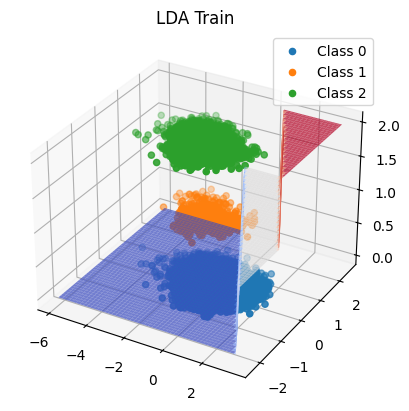

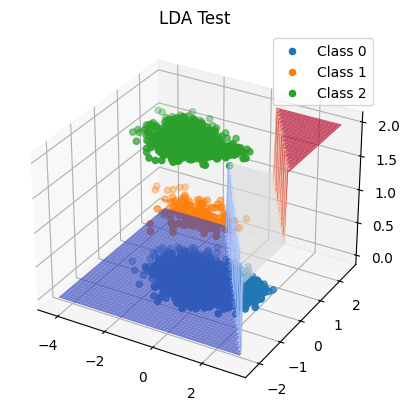

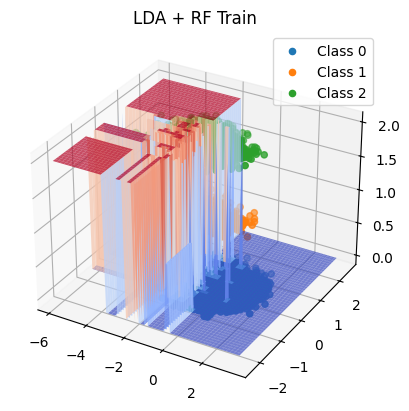

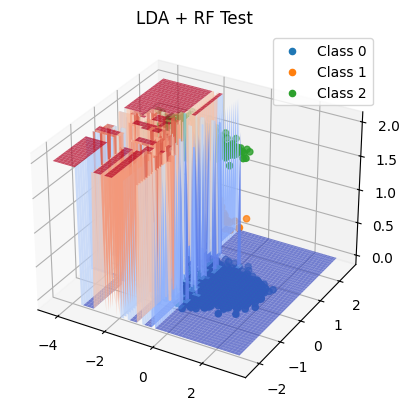

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# These are for the Random Forest Classifier (NOT LDA)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Set seed at 42 for reproducability
sd = 42
np.random.seed(sd)
colors = ['#008080', '#0373d3', '#816cce', '#00ebeb', '#9fa6e9', '#2f1c91']

# Plot a 2D scatter plot for LDA projections with two components
def graph_2D_scatter(X_train, y_train, eigvecs):
    plt.figure(facecolor='#4799eb')

    # Select top two eigenvalues and project them
    W = eigvecs[:, :2]
    X_train_lda = X_train @ W

    # Separate data into classes
    class_0 = X_train_lda[y_train == 0.0]
    class_1 = X_train_lda[y_train == 1.0]
    class_2 = X_train_lda[y_train == 2.0]

    # Plot data in scatter
    plt.scatter(class_0[:, 0], class_0[:, 1], marker=".", color=colors[4], label="Class 0")
    plt.scatter(class_1[:, 0], class_1[:, 1], marker=".", color=colors[2], label="Class 1")
    plt.scatter(class_2[:, 0], class_2[:, 1], marker=".", color=colors[1], label="Class 2")

    plt.legend()
    plt.title("LDA Projection (2D)")
    plt.xlabel("LD1")
    plt.ylabel("LD2")
    plt.savefig("lda_projection_2D.png")
    plt.close()

# Compute and print a confusion matrox
def conf_matrix(y_pred, y_true, title=None):
    confusions = np.zeros((3,3), dtype=int)
    for pred, true in zip(y_pred, y_true):
        confusions[int(pred)][int(true)] += 1

    # Compute the recognition rate
    inputs_correct = np.sum([confusions[i][i] for i in range(3)])
    inputs_total = np.sum(confusions)
    recognition_rate = inputs_correct / inputs_total * 100

    # Print results
    if title:
        print("\n>>> " + title)
    print(
        f"\n    Recognition rate (correct / inputs):\n  {recognition_rate:.2f}%\n"
    )
    print("\tConfusion Matrix:")
    print("\t\t| 0: No Diabetes | 1: Type One | 2: Type Two")
    print("     ---------------------------------------------")
    for i, row in enumerate(confusions):
        print(
            f"{i}: Pred-Class-{i} | "
            + " ".join(f"{val:10d}" for val in row)
        )
    print("\n\n")
    return confusions, recognition_rate

# Perform LDA!
def perform_lda(X_train, y_train, X_test):
    classes = np.unique(y_train)
    mean_vectors = {c: np.mean(X_train[y_train == c], axis=0) for c in classes}
    mean_overall = np.mean(X_train, axis=0)

    # Centralize the data
    X_train_norm = X_train - mean_overall
    X_test_norm = X_test - mean_overall

    num_features = X_train.shape[1]
    wc_ms = np.zeros((num_features, num_features)) # within-class scatter matrix
    bc_ms = np.zeros((num_features, num_features)) # between-class scatter matrix

    # Calculate the scatter matrices
    for c in classes:
        class_data = X_train[y_train == c]
        mean_c = mean_vectors[c].reshape(-1, 1)
        wc_ms += np.sum([(x.reshape(-1, 1) - mean_c) @ (x.reshape(-1, 1) - mean_c).T for x in class_data], axis=0)
        num_samples_c = class_data.shape[0]
        mean_diff = (mean_vectors[c] - mean_overall).reshape(-1, 1)
        bc_ms += num_samples_c * (mean_diff @ mean_diff.T)

    # Get eigenvalues and eigenvectors for new matrix
    new_mat = np.linalg.pinv(wc_ms) @ bc_ms
    eigenvalues, eigenvectors = np.linalg.eig(new_mat)

    # Sort eigenvalues and eigen vectors into ascending order
    sorted_indices = np.argsort(-eigenvalues.real)
    eigvecs = eigenvectors[:, sorted_indices].real

    # Plot a 2D_scatter matrix
    graph_2D_scatter(X_train_norm, y_train, eigvecs)

    # Function ro project data onto selected eigenvectors (n components)
    def project_data(n_components):
        W = eigvecs[:, :n_components]
        W = eigvecs[:, :n_components]
        X_train_lda = X_train_norm @ W
        X_test_lda = X_test_norm @ W
        return X_train_lda, X_test_lda

    return project_data

# LDA classification using euclidean distance to class means
def lda_search_fn(X_train_lda, y_train, X_test_lda, y_test, get_cms=False):
    # Calculate mean for each class in projected data
    class_means_lda = {c: np.mean(X_train_lda[y_train == c], axis=0) for c in np.unique(y_train)}

    # Predict by finding the closest class mean for a given point
    def predict(x):
        distances = {c: np.linalg.norm(x - mean) for c, mean in class_means_lda.items()}
        return min(distances, key=distances.get)

    # Predict for all test samples
    y_pred = np.array([predict(x) for x in X_test_lda])

    # Print confusion matrices (optional)
    if get_cms: conf_matrix(y_pred, y_test, title = "LDA Classifier Results")
    return accuracy_score(y_test, y_pred)

# Search function for Random Forest
def rf_search_fn(X_train, y_train, X_test, y_test, n_estimators):
    #Insantiate and fit RF classifier
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=sd)
    rf_classifier.fit(X_train, y_train)
    # Predict and return accuracy
    y_pred = rf_classifier.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Plot accuracies as line plots
def plot_accuracies(x_values, accuracies, xlabel, ylabel, title, label=None):

    plt.plot(x_values, accuracies, marker='o', label=label, color=colors[-1])
    colors.pop() # removing the used color to make it pretty

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14)

    plt.grid(True, linestyle='--', color='gray', alpha=0.6)

    if label:
        plt.legend()

# Plot different accuracies for RF in a bar plot for comparison
def plot_accuracies_bar(rf_data):
    categories = list(rf_data.keys())
    categories = [str(key) for key in rf_data.keys()]
    values = list(rf_data.values()) # Get accuracies

    # Create the bar plot
    #plt.figure(figsize=(8, 5))
    fig = plt.figure(facecolor='#4799eb')

    plt.bar(categories, values, color=colors, edgecolor='#120e24ff')

    # Labels and title
    plt.xlabel('Number of Components')
    plt.ylabel('Accuracy')
    plt.title('RF Accuracy With/Without LDA Reduction (n_estimators=100)')
    plt.ylim(0.75, 0.85)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # saving plot
    plt.savefig("accuracies_rf_bar.png")


# Function to combine LDA and Random Forest in a pipeline
def lda_rf_pipeline(X_train, y_train, X_test, y_test, n_components_list, n_estimators_list):
    plt.figure(facecolor='#4799eb') #initialize for plot
    rf_data = {} # store rf accuracy data
    # LDA projection function
    compute_projection = perform_lda(X_train, y_train, X_test)

    # Compute LDA accuracy for different numbers of components
    lda_accuracies = []
    for n_components in n_components_list:
        print(f"Testing LDA with {n_components} components")
        X_train_lda, X_test_lda = compute_projection(n_components) # projecting the data
        acc = lda_search_fn(X_train_lda, y_train, X_test_lda, y_test, get_cms=True)
        lda_accuracies.append(acc)

    # Plot the accuracies
    plot_accuracies(n_components_list, lda_accuracies, "Number of Components", "Accuracy",
                    "LDA Accuracy by Number of Components", label="LDA")


    # Get RF data with and without LDA
    rf_no_lda_accuracies = []
    for n_estimators in n_estimators_list:
        rf_no_lda_acc = rf_search_fn(X_train, y_train, X_test, y_test, n_estimators)
        rf_no_lda_accuracies.append(rf_no_lda_acc)

        #If the current number of estimators is the maximum in the list, store the accuracy for the bar plot
        if n_estimators == max(n_estimators_list): rf_data["No LDA"] = rf_no_lda_acc
        rf_accuracies = []
        for n_components in n_components_list:
            print(f"Testing RFxLDA with {n_components} components and {n_estimators} estimators")

            # Compute LDA projections
            X_train_lda, X_test_lda = compute_projection(n_components)

            # Random forest classification on the LDA-reduced data
            acc = rf_search_fn(X_train_lda, y_train, X_test_lda, y_test, n_estimators)

            #If the current number of estimators is the maximum in the list, store the accuracy for the bar plot
            if n_estimators == max(n_estimators_list): rf_data[n_components] = acc
            rf_accuracies.append(acc)

        plot_accuracies(n_components_list, rf_accuracies, "Number of Components", "Accuracy",
                        f"RF Accuracy (n_estimators={n_estimators}) vs LDA", label=f"RF (n={n_estimators})")

    plt.legend()

    plt.savefig("lda_rf_accuracy_comparison.png")
    #plt.show()


    for i, acc in enumerate(rf_no_lda_accuracies):
        print(f"RF with no LDA (n_estimators={n_estimators_list[i]}) accuracy: {acc}\n")

    # Create a bar chart comparing Random Forest accuracies with and without LDA
    plot_accuracies_bar(rf_data)

# Function to visualize LDA and LDA+RF decision boundaries in 3D
def plot_3D_classes(X_train, y_train, X_test, y_test):

    # Ensure that results folder exists
    os.makedirs("lda_results", exist_ok=True)
    compute_projection = perform_lda(X_train, y_train, X_test)
    X_train_lda, X_test_lda = compute_projection(2) #Project to two components

    # Initialize rf classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train_lda, y_train)

    # Helper functions to generate decision boundaries for LDA and LDA+RF
    def lda_classifier(grid_points):
        distances = [
            np.linalg.norm(grid_points - mean, axis=1) for mean in np.unique(y_train)
        ]
        return np.hstack([grid_points, np.argmin(distances, axis=0).reshape(-1, 1)])

    # LDA + RF Classifier
    def lda_rf_classifier(grid_points):
        class_scores = rf_classifier.predict_proba(grid_points)
        return np.hstack([grid_points, class_scores.argmax(axis=1).reshape(-1, 1)])

    # Generate 3D Contours
    def draw_contours(data_matrix, class_fn, title, file_name):
        # Determine range for the plot
        x_min, x_max = data_matrix[:, 0].min() - 1, data_matrix[:, 0].max() + 1
        y_min, y_max = data_matrix[:, 1].min() - 1, data_matrix[:, 1].max() + 1

        # Generate grid of points
        x = np.linspace(x_min, x_max, 100)
        y = np.linspace(y_min, y_max, 100)
        xx, yy = np.meshgrid(x, y)
        grid_points = np.c_[xx.ravel(), yy.ravel()]

        # Compute the decision boundaries
        Z = class_fn(grid_points)[:, -1].reshape(xx.shape)

        # Create the 3D plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot the decision boundary as a surface
        ax.plot_surface(xx, yy, Z, cmap='coolwarm', edgecolor='none', alpha=0.7)

        # Create scatter plot for individual data points
        classes = np.unique(data_matrix[:, -1])
        for cls in classes:
            # Filter the points belonging to current class
            cls_points = data_matrix[data_matrix[:, -1] == cls]

            # Plot the points below the decision surface
            ax.scatter(
                cls_points[:, 0], # X coordinates
                cls_points[:, 1], # Y coordinates
                np.full(cls_points.shape[0], cls), # Z coordinate
                label = f"Class {int(cls)}",
                s = 20,
            )

        ax.set_title(title)
        ax.legend()

        # Save the plot as an img
        plt.savefig(file_name)
        # Display the plot
        plt.show()

    # Generate Contours for Train and Test Sets
    draw_contours(
        np.column_stack((X_train_lda, y_train)),
        lda_classifier,
        "LDA Train",
        "lda_train_3d.png",
    )
    draw_contours(
        np.column_stack((X_test_lda, y_test)),
        lda_classifier,
        "LDA Test",
        "lda_test_3d.png",
    )
    draw_contours(
        np.column_stack((X_train_lda, y_train)),
        lda_rf_classifier,
        "LDA + RF Train",
        "lda_rf_train_3d.png",
    )
    draw_contours(
        np.column_stack((X_test_lda, y_test)),
        lda_rf_classifier,
        "LDA + RF Test",
        "lda_rf_test_3d.png",
    )



# Process data file and apply searches
def process_data_file(file_path, n_estimators_list, lda_rf=True, plot_3D=False):
    print(f"\nProcessing file: {file_path}")
    data = pd.read_csv(file_path) # Read in files
    data = data.sample(frac=0.2, random_state=42) # Get smaller fraction of data for faster computation
    X = data.iloc[:, 1:].values
    y = data.iloc[:, 0].values

    # Split data into train/test sets
    split_ratio = 0.8
    indices = np.random.permutation(len(X))
    split_index = int(len(X) * split_ratio)
    X_train, X_test = X[indices[:split_index]], X[indices[split_index:]]
    y_train, y_test = y[indices[:split_index]], y[indices[split_index:]]

    # Specify LDA component range for grid search
    max_components = 12
    n_components_list = list(range(1, max_components + 1))

    if lda_rf:
        print("\nLDA + Random Forest Pipeline:")
        lda_rf_pipeline(X_train, y_train, X_test, y_test, n_components_list, n_estimators_list)
    if plot_3D:
        print("\nLDA + Random Forest 3D Plot:")
        plot_3D_classes(X_train, y_train, X_test, y_test)

# Define data files and parameters
data_files = [
    "/dataset.csv"
]
n_estimators_list = [25, 50, 100]

# Process each data file
for file_path in data_files:
    process_data_file(file_path, n_estimators_list, lda_rf = False, plot_3D = True)